# Computer Vision Project - Character Font Recognition

## Author: Tal Rave

In this document, I present my work in a succinct and mostly visual manner. Please, see the attached PDF file for more details.

## Table of Contents

- [Data Exploration](#exp)
    - Where I check and show what the data contains.
- [Data Preparation](#prp)
    - Where I present my data preparation procedures.
- [Model Evaluation](#evo)
    - Where I show my progressive improvement.

Import the libraries...

In [1]:
from head import *
from prep import * 
from test import *

from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb

# Set display quality.
plt.rcParams['figure.dpi'] = 140 

def strToCol(s): # Converts strings to colors.
    return 255 * np.array(to_rgb(s))

MAGENTA = strToCol('magenta')
CYAN = strToCol('cyan')

<a id='exp'></a>
## Data Exploration

Load the training set...

In [2]:
train_h5_name = 'SynthText_train.h5'
train_db = h5py.File(train_h5_name, 'r') 
train_names = list(train_db['data'].keys())
setDB(train_db, train_names) # Set db globals.
setInter(cv2.INTER_CUBIC) # Set interpolation method.
setImgSz(64) # Set character image size.
setFilSz(5) # Set morphology filter size.

Load a few examples...

In [3]:
samples = [getDatPt(n) for n in train_names[:16]]

Display a few images...

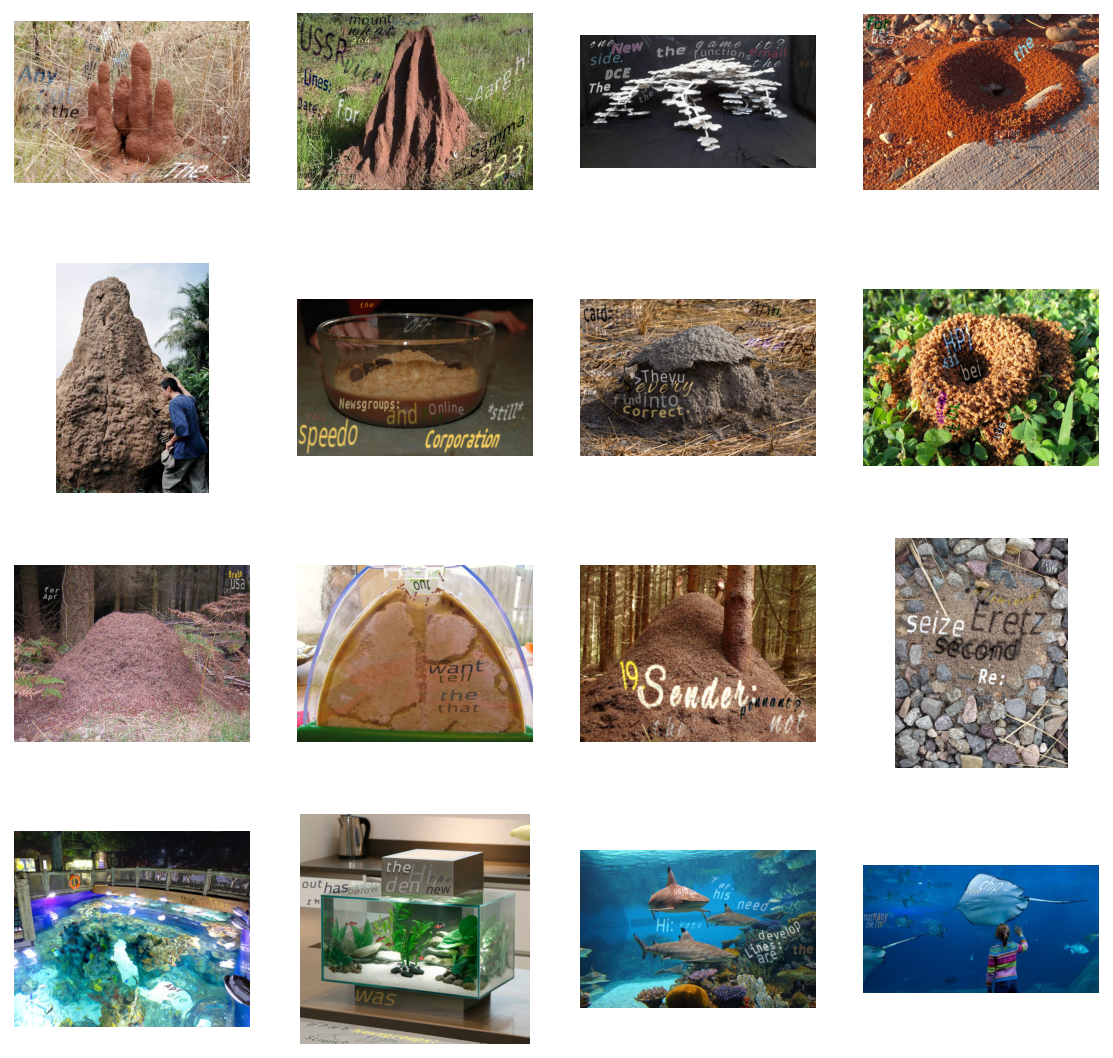

In [4]:
plt.figure(figsize=(10,10))
for i, s in enumerate(samples, 1):
    plt.subplot(4,4,i)
    plt.imshow(s[IMG])
    plt.axis('off')

It looks like the dataset contains images of great diversity. Also, the characters/words are of varying colors and seem to have had various transformations applied on them (scaling, rotation, shearing, warping, etc.).

Display some bounding box annotations...

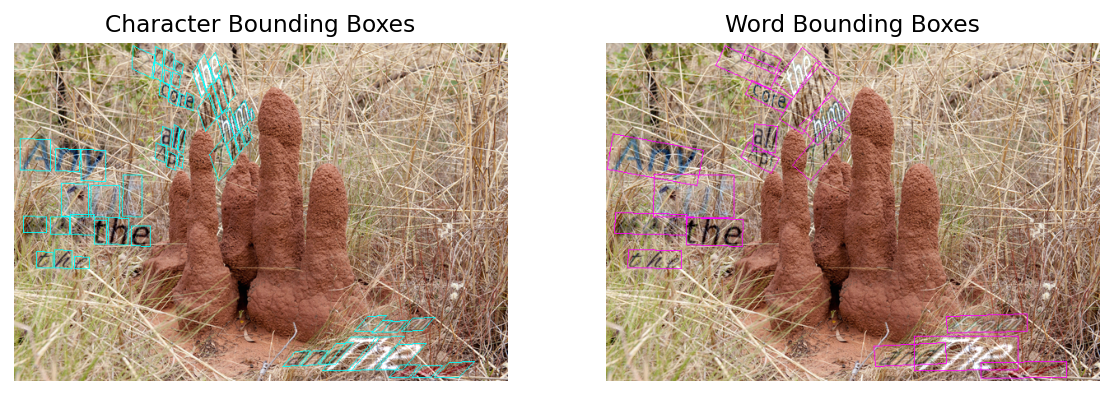

In [5]:
img, cBB, wBB = samples[0][IMG], samples[0][CBB], samples[0][WBB]

plt.figure(figsize=(10,5))
for i, (BB, t, c) in enumerate([[cBB, 'Character Bounding Boxes', CYAN], 
                                [wBB, 'Word Bounding Boxes', MAGENTA]], 1):
    copy = np.copy(img)
    for bb in BB.transpose([2,1,0]):
        pts = bb.reshape((-1,1,2)).astype(int)
        cv2.polylines(copy, [pts], True, c)
    plt.subplot(1,2,i)
    plt.imshow(copy)
    plt.title(t)
    plt.axis('off');
    
del samples

We can see that some characters are almost invisible.

Display the distribution of the various characters...

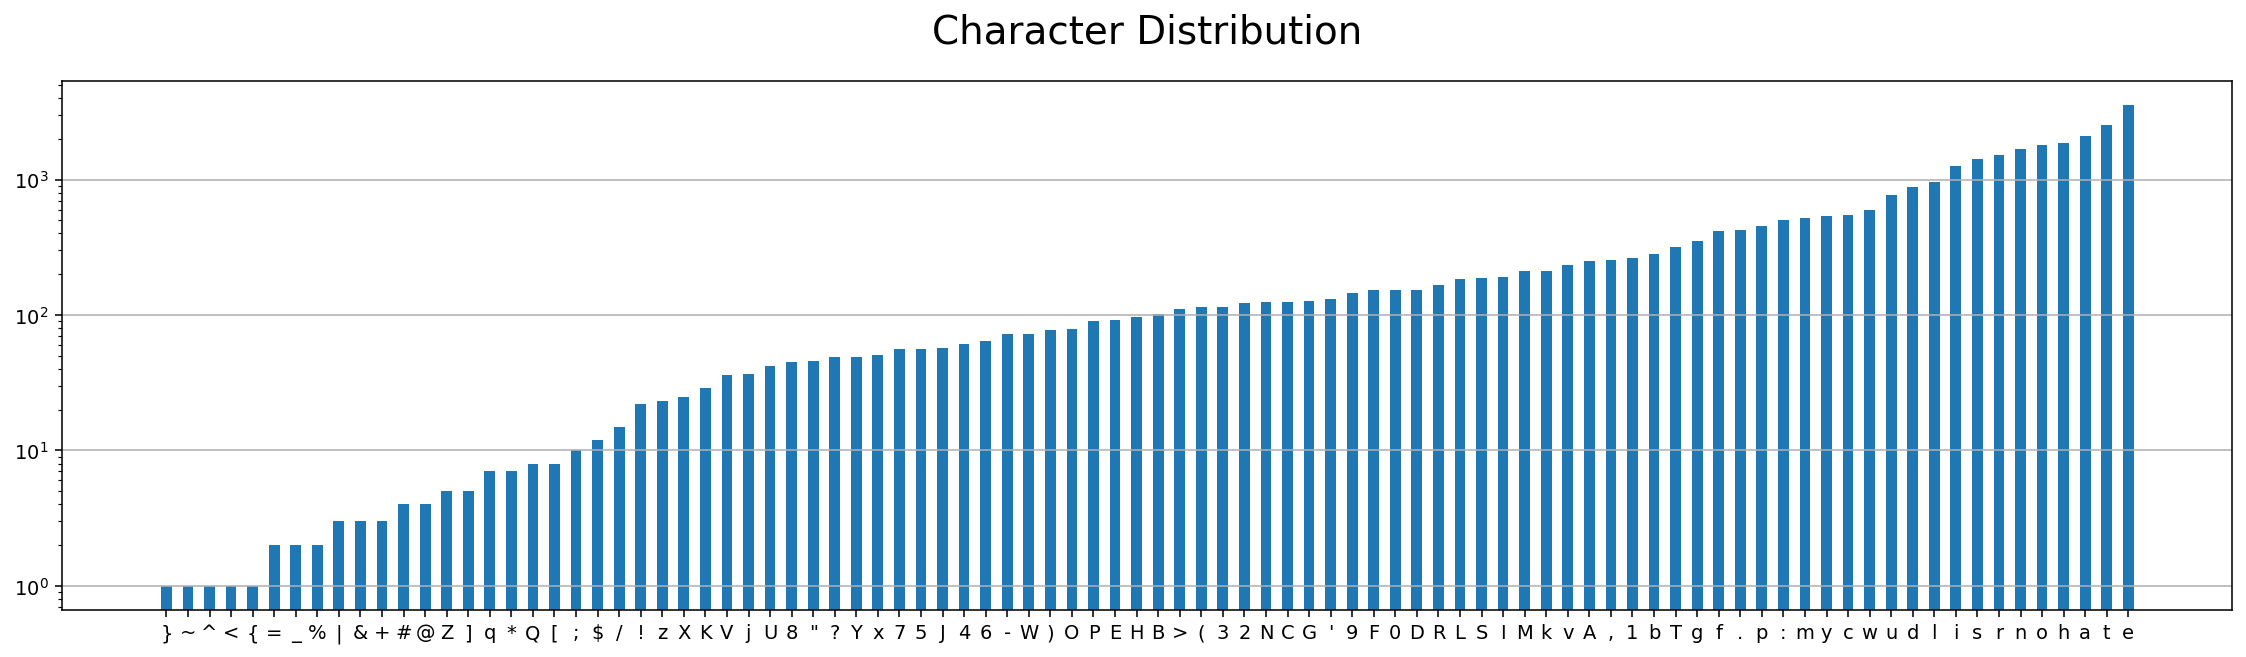

In [6]:
txt = [getDatPt(n)[TXT] for n in train_names]

# Prepare a dictionary of characters from the txt data.
chrDct = {}
for t in txt:
    for b in t:
        for c in b:
            try:
                chrDct[chr(c)] += 1
            except:
                chrDct[chr(c)] = 1

# Sorts the received dictionary.
def srt(dct):
    idx = np.argsort(list(dct.values()))
    keys = np.array(list(dct.keys()))[idx]
    vals = np.array(list(dct.values()))[idx]    
    return keys, vals
    
# Sort the characters by their number.
chrKeys, chrVals = srt(chrDct)
    
# Display histograms.
plt.figure(figsize=(20,5))
plt.bar(chrKeys, chrVals, width=0.5)
plt.yscale('log')
plt.grid(axis='y')
plt.title('Character Distribution', fontsize=20, y=1.05);

del txt, chrDct

As expected, we can see that some characters appear a lot more frequently than others. Our task is to recognize only their font however, and so it matters little. Note that the above plot is in log-scale. 

Display the font distribution...

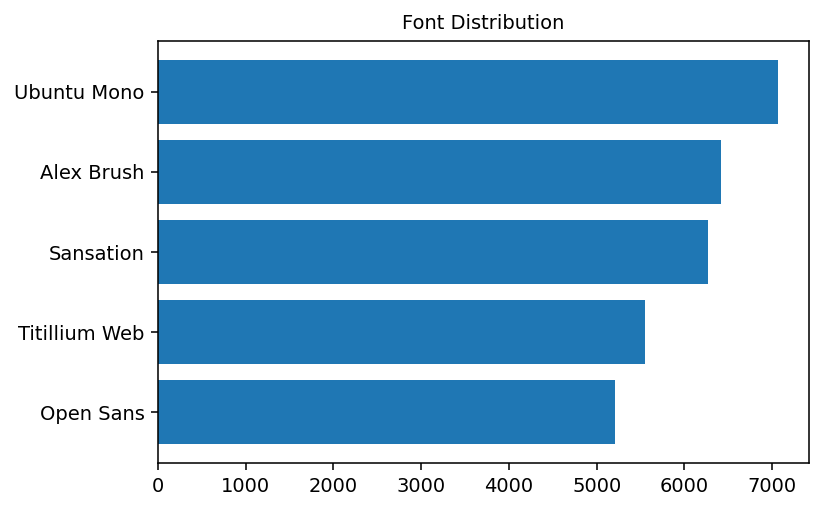

In [7]:
fnts = [getDatPt(n)[FNT] for n in train_names]

# Prepare a dictionary of fonts.
fntDct = {}
for fs in fnts:
    for f in fs:
        try:
            fntDct[f] += 1
        except:
            fntDct[f] = 1 
    
# Display the histograms.
plt.barh(*srt(fntDct))
plt.title('Font Distribution', fontsize=10);

del fnts, fntDct

We can see that the data is quite balanced in terms of the font distribution.

<a id='prp'></a>
## Data Preparation

As we saw, the character boxes are not necessarily aligned with the image axes, and so the first step of my solution involves per-character cropping by computing the matrix that transforms a given box to the desired coordinates such that the result is an image of the desired size containing the transformed character. Note that I use cubic interpolation - this improves performance somewhat.

Display some extracted characters...

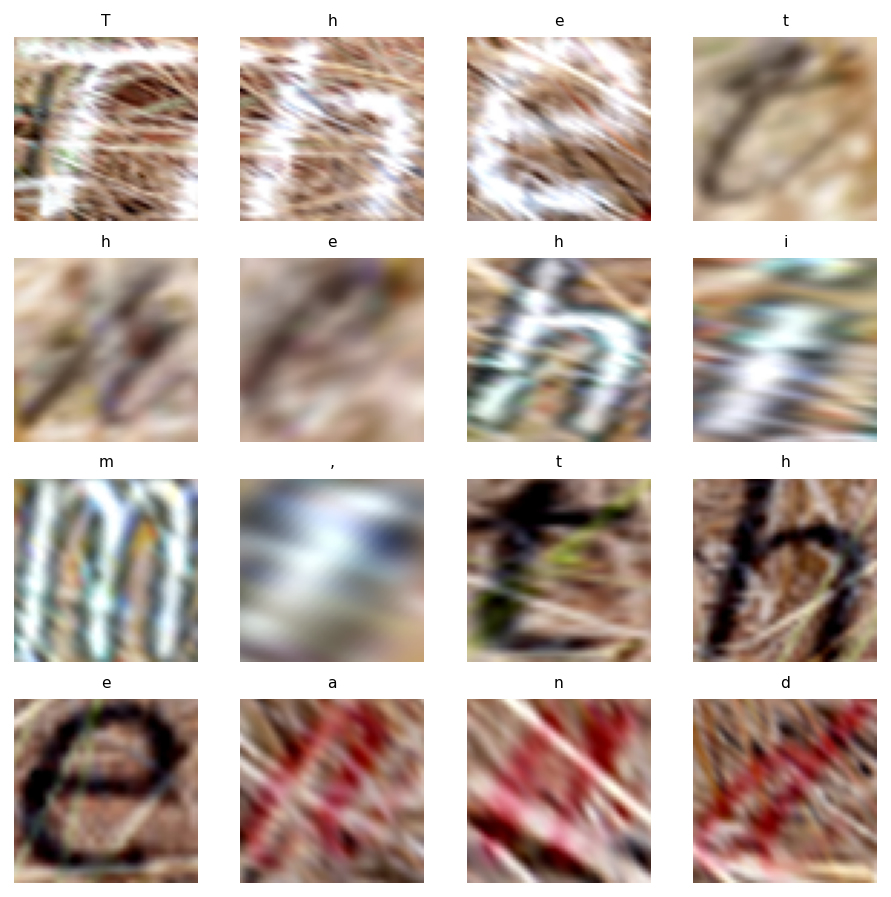

In [8]:
sample = getDatPt(train_names[0])
img, BB, chrs = sample[IMG], sample[CBB].transpose([2,0,1]), [chr(c) for t in sample[TXT] for c in t]

idx = 0
plt.figure(figsize=(8,8))
for i, (bb, c) in enumerate(zip(BB[:4**2], chrs[:4**2]), 1):
    plt.subplot(4, 4, i)
    crop = extChr(img, bb)
    plt.imshow(crop)
    plt.title(c, fontsize=8)
    plt.axis('off')

The method works correctly. However, the background noise is irrelevant and a potential hindrance, and so as a preprocessing step, I apply an opening morphology followed by a closing morphology. I should mention that other filtering techniques did not seem to yield any measurable benefit.

Display the above images after preprocessing...

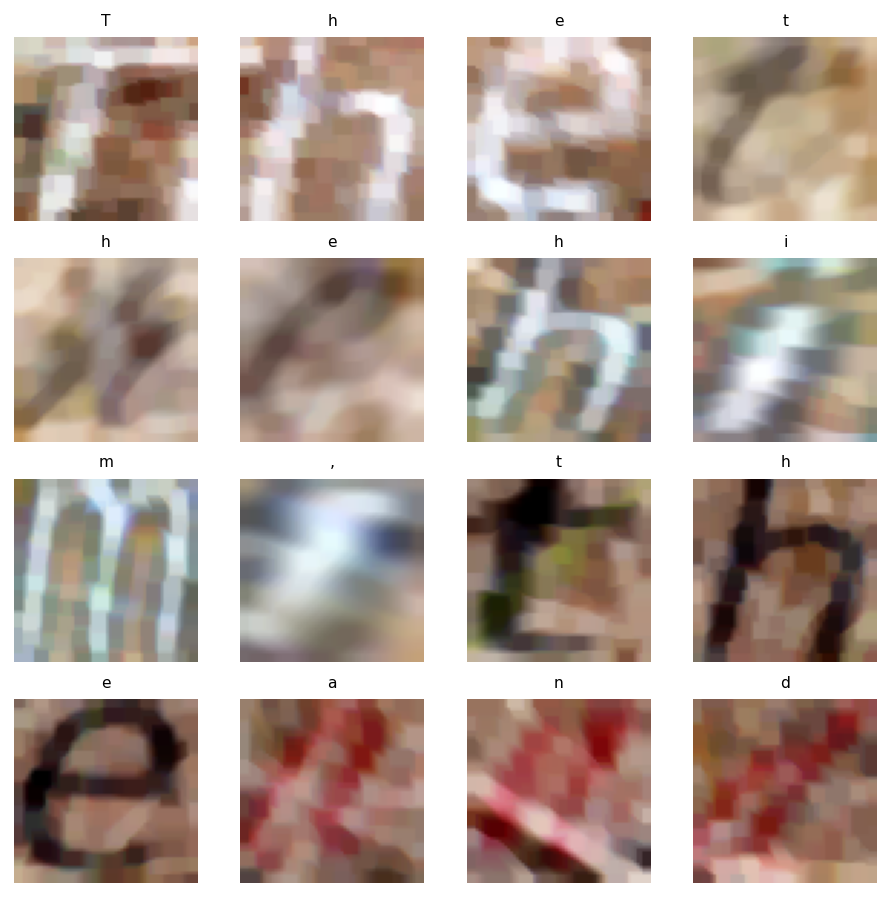

In [9]:
plt.figure(figsize=(8,8))
for i, (bb, c) in enumerate(zip(BB[:4**2], chrs), 1):
    plt.subplot(4, 4, i)
    crop = clnChr(extChr(img, bb))
    plt.imshow(crop)
    plt.title(c, fontsize=8)
    plt.axis('off')

We can see that the morphologies preserved the shape and edge information of the characters while attenuating the background noise. Note that I use color images; color information may not be relevant for the purpose of font recognition, but in our case, it can be exploited to distinguish the characters from the remaining background noise (e.g., look at the last few red characters in the above plot).

As I alluded to, the most useful features that can be extracted from the preprocessed images are probably related to changes in intensity/color; an excellent choice for obtaining such statistics is HOG features - I use my unique version; each image is divided into a 16x16 grid of cells, the derivatives in each cell are computed using a large 7x7 Sobel filter, and the gradient magnitudes that are maxima along the color channel are 8-binned according to their angles.

Display the magnitudes and angles derived from the cleaned images...

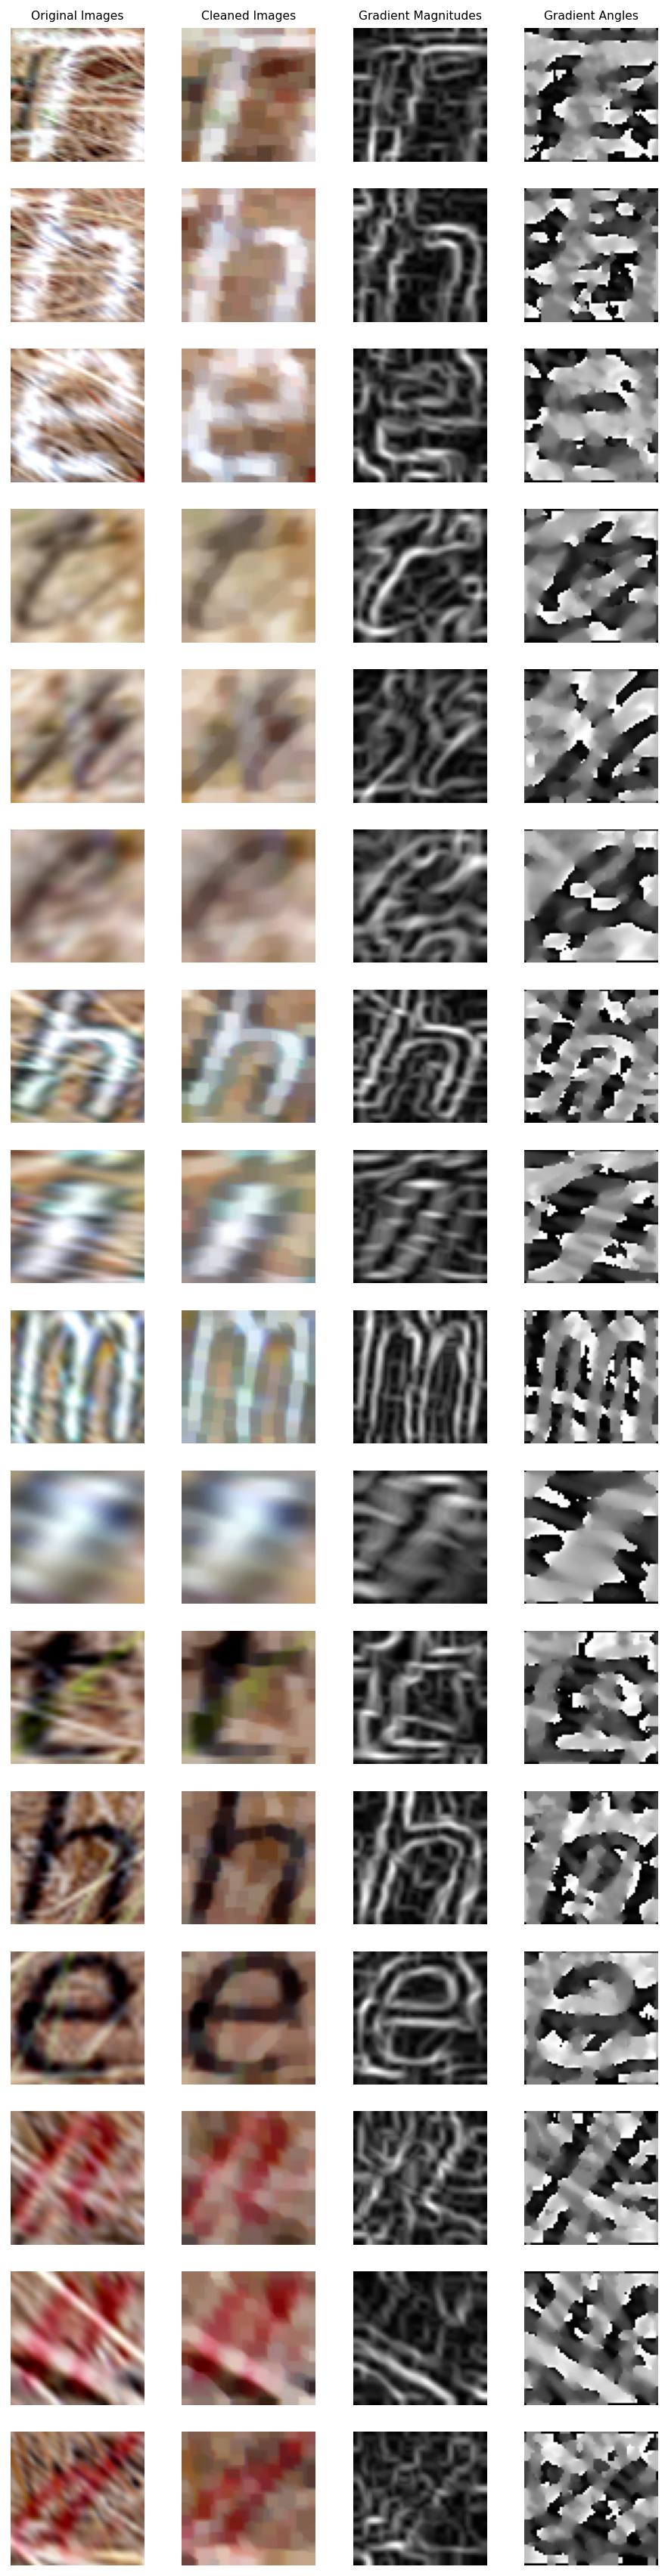

In [10]:
plt.figure(figsize=(8, 8*16))
for i, (bb, c) in enumerate(zip(BB[:4**2], chrs)):
    ori = extChr(img, bb)
    cln = clnChr(ori)
    for j, h in enumerate([ori, cln] + list(hog(cln)[1:])):
        k = 4*i+j+1
        if k == 2:
            plt.title('Original Images', fontsize=8)
        elif k == 3:
            plt.title('Cleaned Images', fontsize=8)
        elif k == 4:
            plt.title('Gradient Magnitudes', fontsize=8)
        elif k == 5:
            plt.title('Gradient Angles', fontsize=8)
        plt.subplot(4*16, 4, k)
        plt.imshow(h, cmap='gray')
        plt.axis('off')
        
del sample, img, BB, chrs

The data preparation procedure will produce two corresponding lists X_data and y_data such that:

- Every X in X_data is a data point of shape (Ni, d) (i.e., the HOG representations).
- Ni is the number of characters extracted from image i.
- d is the feature vector size.
- Every y in y_data is a metadata point of shape (Ni, 4).
- y[:, 0] are the image indices.
- y[:, 1] are the word indices.
- y[:, 2] are the characters.
- y[:, 3] are the font labels (i.e., 0, 1, 2, 3, or 4).
- The last one will not be created if there are no fonts.

<a id='evo'></a>
# Model Evaluation

I use a KNN model based on cosine distances. To improve performance even further, I also use per-word weighted voting to determine the final class prediction of characters that belong to the same word. To validate the results and select an optimal k value, I run 10-fold cross-validation procedures. Note that our examples are whole images along with their metadata, and so characters that belong to the same image should always be in the same set.

To justify my choices, I first present the cumulative effects on performance of the different model elements...

In [11]:
np.random.shuffle(train_names)
X_data = None
y_data = None
K = list(range(1,11))
# A simple testing method I use to show the cumulative effects on performance of the different model elements.
def test(fCln=lambda x: x, fFeat=lambda x: x.reshape(-1), 
         fPred=lambda m,x: m.predict(x), fVote=lambda x,y: x,
         w='uniform', d='minkowski'):

    # Prepare the data.
    global X_data
    global y_data
    X_data, y_data = prepData(fCln=fCln, fFeat=fFeat)
    
    # Perfroms cross-validations to obtain an optimal k for KNN.
    global kOpt
    means = []
    stds = []
    for k in K:
        mean, std = cv(KNN(k, weights=w, metric=d), X_data, y_data, fPred=fPred, fVote=fVote)
        means.append(mean)
        stds.append(std)
    kOptIdx = np.argmax(means)
    mOpt = means[kOptIdx]
    sOpt = stds[kOptIdx]
    kOpt = K[kOptIdx]
    
    # Visualize results.
    plt.scatter( # Mark optimal k.
    kOpt, mOpt, c='white', s=100, edgecolors='red') 
    plt.plot(K, means)
    plt.errorbar(K, means, yerr=stds, capsize=10, c='gray') # Plot std intervals.
    plt.scatter(K, means, c='black')
    plt.xticks(K)
    plt.xlabel('k')
    plt.ylabel('Mean Accuracy (+/- std)')
    plt.grid(axis='x')
    plt.grid(axis='y')
    plt.show()
    print(f'Accuracy(k={kOpt}) = {round(mOpt, 4)}.') 
    print(f'Deviation(k={kOpt}) = {round(sOpt, 4)}.') 
    
    return mOpt, sOpt, kOpt

My initial solution was a default KNN model, using small 32x32 flattened character images, and no preprocessing of any kind...

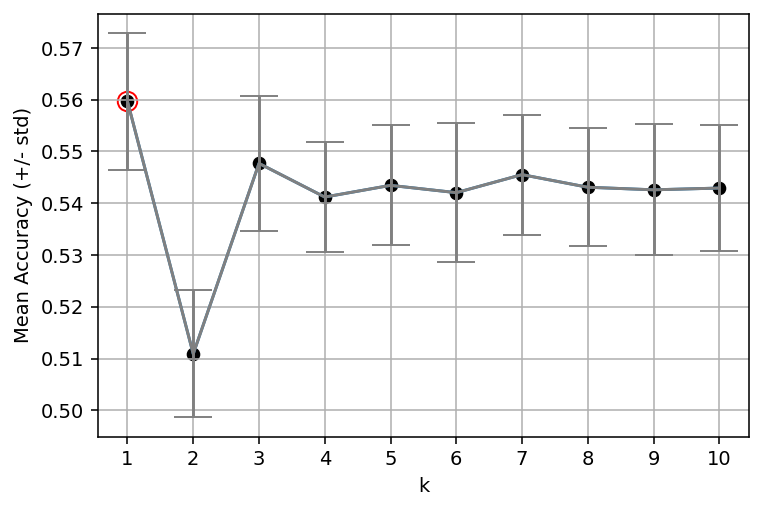

Accuracy(k=1) = 0.5597.
Deviation(k=1) = 0.0132.


In [12]:
imp = []
setImgSz(32)
setInter(cv2.INTER_LINEAR)
imp.append(['Initial Solution', test()])

Then I changed the interpolation method to 'cubic' during character extraction...

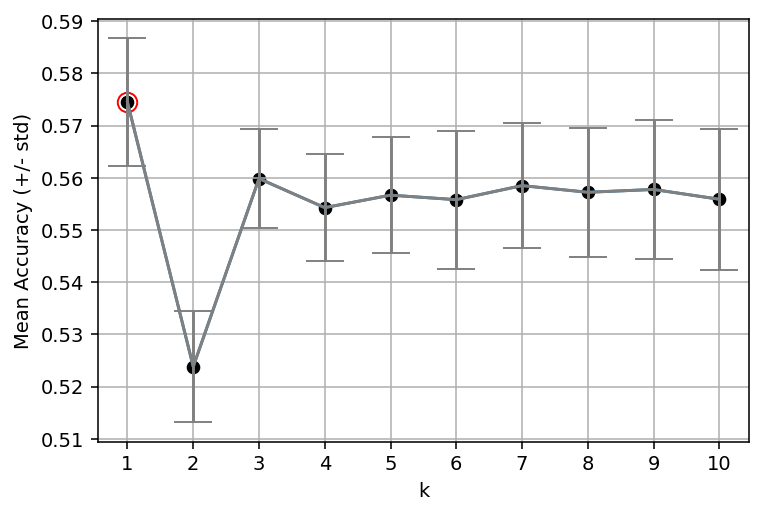

Accuracy(k=1) = 0.5745.
Deviation(k=1) = 0.0123.


In [13]:
setInter(cv2.INTER_CUBIC)
imp.append(['Cubic Interpolation', test()])

Using plain images was not very promising, and so I used HOG features...

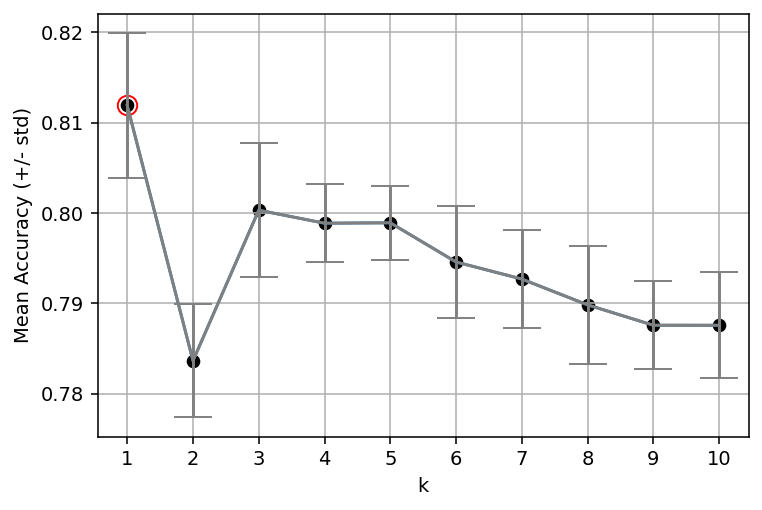

Accuracy(k=1) = 0.8119.
Deviation(k=1) = 0.008.


In [14]:
imp.append(['HOG Features', test(fFeat=lambda x: hog(x)[0])])

But the HOG features were not normalized; an alternative to data normalization is the cosine distance metric...

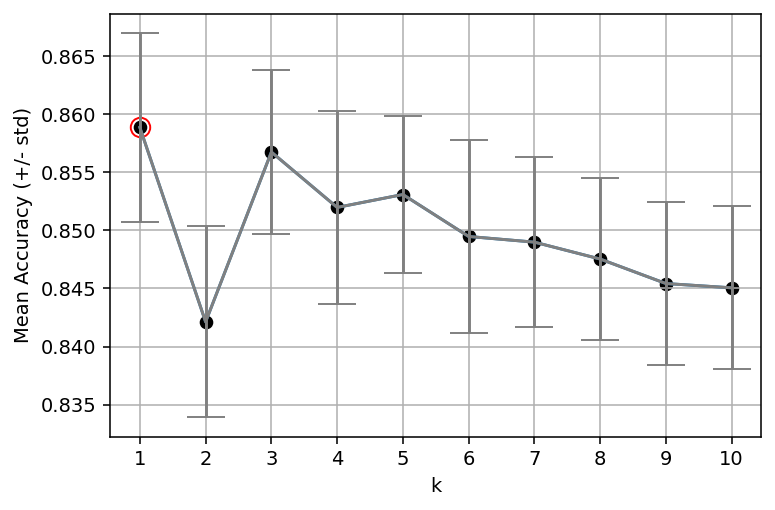

Accuracy(k=1) = 0.8589.
Deviation(k=1) = 0.0081.


In [15]:
imp.append(['Cosine Distance', test(fFeat=lambda x: hog(x)[0], d='cosine')])

Great, but using weights for the distances might be better...

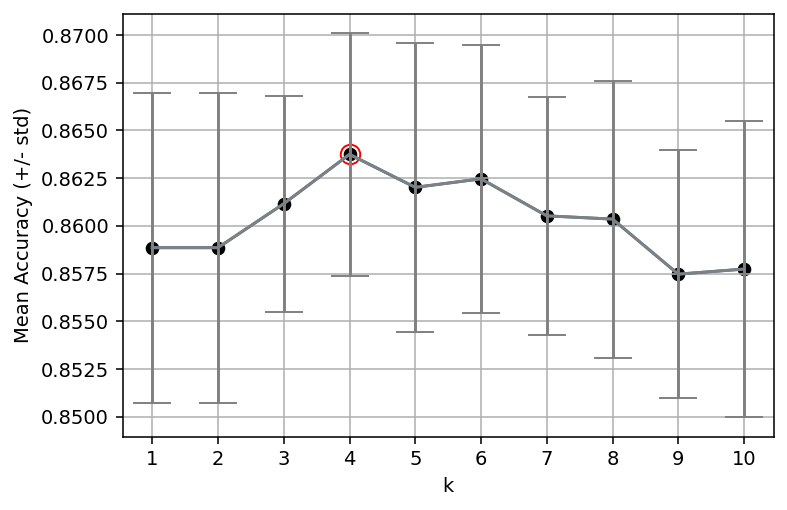

Accuracy(k=4) = 0.8637.
Deviation(k=4) = 0.0064.


In [16]:
imp.append(['Distance Weights',
            test(fFeat=lambda x: hog(x)[0], w='distance', d='cosine')])

Characters are the building blocks of words. Surely, there should be a vote before making a final decision...

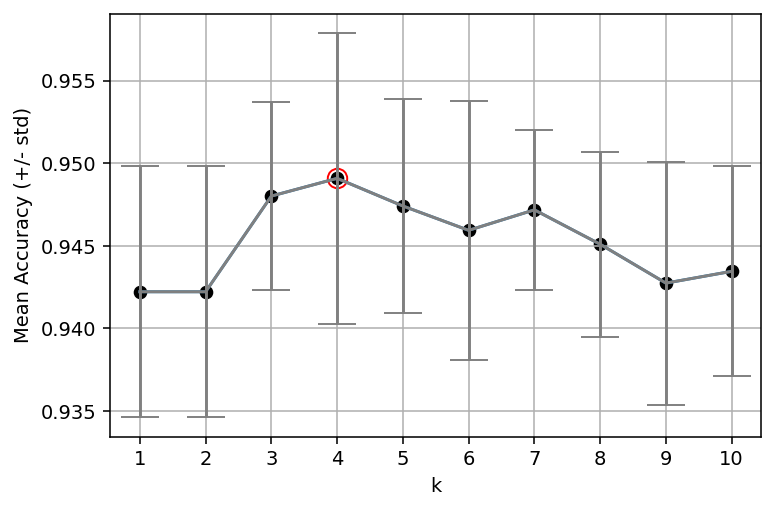

Accuracy(k=4) = 0.9491.
Deviation(k=4) = 0.0088.


In [17]:
imp.append(['Majority Voting', 
            test(fFeat=lambda x: hog(x)[0], fVote=majVot, w='distance', d='cosine')])

Nice, but using the inverse distances as weights for the votes should be even better...

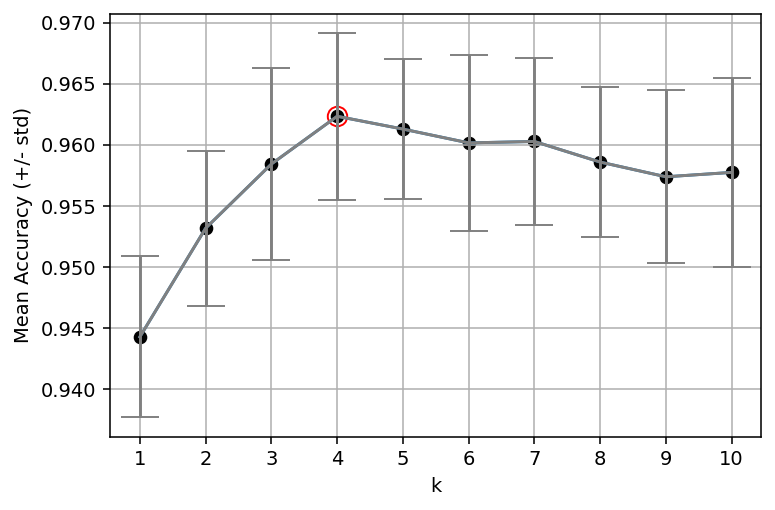

Accuracy(k=4) = 0.9623.
Deviation(k=4) = 0.0068.


In [18]:
imp.append(['Weighted Voting',
            test(fFeat=lambda x: hog(x)[0], fPred=distScrs, fVote=majVot, w='distance', d='cosine')])

Let's increase the size of the extracted characters and add some background noise reduction before feature extraction; an opening morphology followed by a closing morphology, resulted in a modest increase in accuracy...

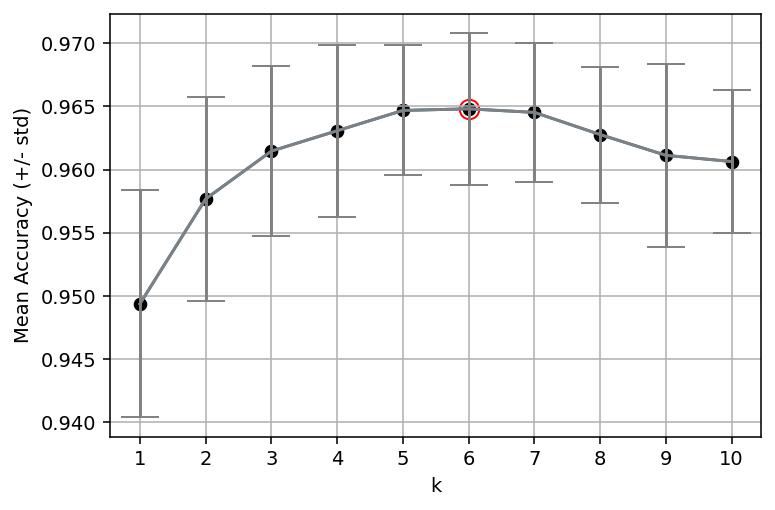

Accuracy(k=6) = 0.9648.
Deviation(k=6) = 0.006.


In [19]:
setImgSz(64)
imp.append(['Opening & Closing',
            test(fCln=clnChr, fFeat=lambda x: hog(x)[0], fPred=distScrs, fVote=majVot, w='distance', d='cosine')])

Let's recap...

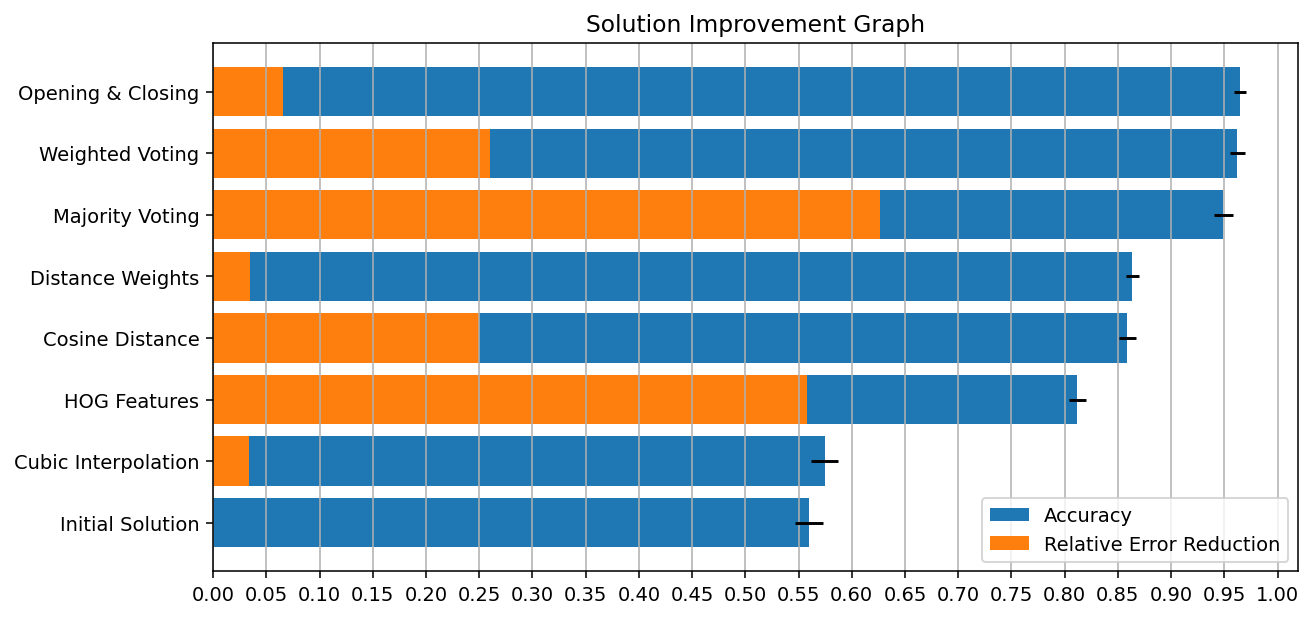

In [20]:
plt.figure(figsize=(10,5))
n = [m[0] for m in imp] # Element names.
a = np.array([m[1][0] for m in imp]) # Accuracy scores.
s = np.array([m[1][1] for m in imp]) # stds.
plt.barh(n, a, label='Accuracy', xerr=s)
plt.barh(n[1:], (1 - (1-a) / np.roll(1-a, 1))[1:], 
         label='Relative Error Reduction')
plt.xticks(np.arange(21) / 20)
plt.grid(axis='x')
plt.title('Solution Improvement Graph')
plt.legend();

In the above plot, each bar includes all the elements below it as well (i.e., each blue bar marks the accuracy of the combination, whereas the orange bar marks the relative error reduction obtained by adding the respective element). The small line segments at the end of the bars represent the standard deviations; they indicate that the model also improves in robustness (i.e., w.r.t. different splits of the data during cross-validation).

Fit an appropriate model to the entire dataset...

In [21]:
X_data = np.concatenate(X_data)
y_data = np.concatenate(y_data)
model = KNN(imp[-1][1][-1], weights='distance', metric='cosine').fit(X_data, y_data[:,-1])

del X_data, y_data

Save the model...

In [22]:
pkl = open('model', 'wb') 
pickle.dump(model, pkl)  
pkl.close()